In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

In [35]:
# ! pip install category_encoders

In [36]:
data = pd.read_csv(r'../data/historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## EDA

In [37]:
# Quick overview
print("Shape:", data.shape)
print("\nColumns:")
print(data.columns.tolist())


Shape: (197428, 16)

Columns:
['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']


In [38]:
print("\nData types:")
print(data.dtypes)


Data types:
market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object


In [39]:
print("\nMissing values:")
print(data.isna().sum())


Missing values:
market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [40]:
categorical_cols = data.select_dtypes(include=["object"]).columns
print("\nCategorical columns:")
for col in categorical_cols:
    print(f"{col}: {data[col].nunique()} unique values")


Categorical columns:
created_at: 180985 unique values
actual_delivery_time: 178110 unique values
store_primary_category: 74 unique values


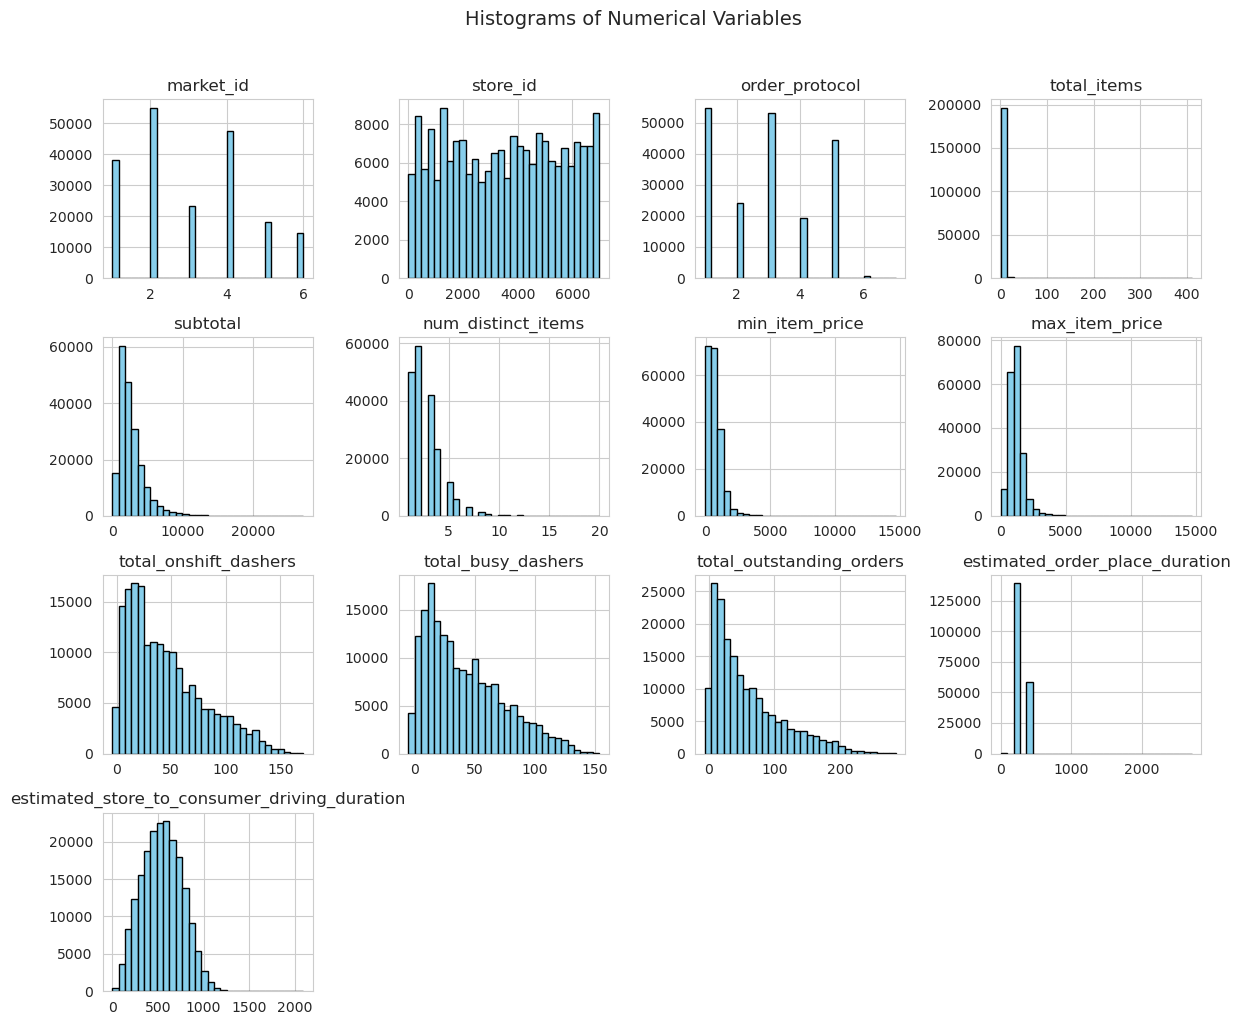

In [41]:
# Histograms for numerical variables
sns.set_style("whitegrid")

numeric_cols = data.select_dtypes(include=['number'])

numeric_cols.hist(
    figsize=(12, 10),
    bins=30,             
    edgecolor='black',    
    color='skyblue'    
)

plt.suptitle("Histograms of Numerical Variables", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Create target value column 

In [42]:
# calculate deliver duration

data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['created_at'] = pd.to_datetime(data['created_at'])
data['target'] =  (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()
data['target']

0         3779.0
1         4024.0
2         1781.0
3         3075.0
4         2390.0
           ...  
197423    3907.0
197424    3383.0
197425    3008.0
197426    3907.0
197427    2228.0
Name: target, Length: 197428, dtype: float64

## Data Cleaning

In [43]:
# remove rows with missing target value
data = data.dropna(subset=['actual_delivery_time', 'created_at'])
print(data.isna().sum())

market_id                                         987
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


In [44]:
# market_id: Missing values are filled using the next row's value.
# This approach assumes that nearby rows in the dataset typically belong to the same market,
# so forward/backward filling is a reasonable approximation.

data['market_id'] = data['market_id'].fillna(method='bfill')  # or 'ffill' depending on data pattern
print(data.isna().sum())

market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


/tmp/ipykernel_1411364/306552265.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['market_id'] = data['market_id'].fillna(method='bfill')  # or 'ffill' depending on data pattern


In [45]:
# store_primary_category: Missing values are replaced with "Other".
# The distribution shows high category diversity and low missing rate (2%),
# so we fill with "Other"
data['store_primary_category'] = data['store_primary_category'].fillna('Other')
print(data.isna().sum())


market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                              0
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


In [46]:
# order_protocol: Missing values are filled using the next row's value (backward fill).
# Since nearby rows in the dataset often belong to the same store or market context,
# so we assume they share a similar order protocol.
data['order_protocol'] = data['order_protocol'].fillna(method='bfill')
print(data.isna().sum())

market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                              0
order_protocol                                      0
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


/tmp/ipykernel_1411364/1599200043.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['order_protocol'] = data['order_protocol'].fillna(method='bfill')


In [47]:
#Filling Missing Values for Marketplace Features
# Since they are count-based and right-skewed, missing values are filled with each column’s **median**, which is more robust to outliers than the mean.
for col in ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']: 
    data[col] = data[col].fillna(data[col].median())

print(data.isna().sum())

market_id                                         0
created_at                                        0
actual_delivery_time                              0
store_id                                          0
store_primary_category                            0
order_protocol                                    0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    0
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration    526
target                                            0
dtype: int64


In [48]:
# estimated_store_to_consumer_driving_duration:
# Missing values are filled with the median, as the feature is continuous and right-skewed.
# Median imputation helps reduce the impact of outliers.

data['estimated_store_to_consumer_driving_duration'] = (
    data['estimated_store_to_consumer_driving_duration']
    .fillna(data['estimated_store_to_consumer_driving_duration'].median())
)
print(data.isna().sum())
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")


market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
target                                          0
dtype: int64
The dataset has 197421 rows and 17 columns.


In [49]:
# Remove the outliers in the target col
# to avoid the noises caused by the outliers

q99 = data['target'].quantile(0.99)

data = data[data['target'] <= q99]

print(f"Data shape after removing top 1% outliers: {data.shape}")


Data shape after removing top 1% outliers: (195446, 17)


In [72]:
features = [
    'target',
    'subtotal',
    'min_item_price',
    'max_item_price',
    'total_items',
    'num_distinct_items',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration'
]

data[features].min()

target                            101.0
subtotal                            0.0
min_item_price                    -86.0
max_item_price                      0.0
total_items                         1.0
num_distinct_items                  1.0
total_onshift_dashers              -4.0
total_busy_dashers                 -5.0
total_outstanding_orders           -6.0
estimated_order_place_duration      0.0
dtype: float64

In [73]:
# Columns that should never have negative values (dirty data)
cols_with_invalid_negatives = [
    'min_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders'
]


# Drop rows where ANY of these columns contain negative values
data = data[~data[cols_with_invalid_negatives].lt(0).any(axis=1)].copy()

print("Shape after cleaning :", data.shape)

Shape after cleaning : (195353, 17)


## Split training/testing dataset

In [75]:
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Encoding for Categorical cols

In [76]:
# Onehot encoding: market_id, order_protocol
# These two features have a small number of categories (6 and 7),
# so one-hot encoding is appropriate.
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit on training data only
encoder.fit(X_train[['market_id', 'order_protocol']])

# Transform train and test sets
train_encoded = encoder.transform(X_train[['market_id', 'order_protocol']])
test_encoded = encoder.transform(X_test[['market_id', 'order_protocol']])

# Convert to DataFrame
train_encoded_df = pd.DataFrame(train_encoded, 
                                columns=encoder.get_feature_names_out(['market_id', 'order_protocol']),
                                index=X_train.index)
test_encoded_df = pd.DataFrame(test_encoded, 
                               columns=encoder.get_feature_names_out(['market_id', 'order_protocol']),
                               index=X_test.index)

# Concatenate encoded features and drop original columns
X_train = pd.concat([X_train.drop(['market_id', 'order_protocol'], axis=1), train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(['market_id', 'order_protocol'], axis=1), test_encoded_df], axis=1)

In [77]:
# Target encoding for high-cardinality categorical features:
# - store_id (~6,743 distinct)
# - store_primary_category (~74 distinct)
from category_encoders import LeaveOneOutEncoder

cat_cols = ['store_id', 'store_primary_category']

# Leave-One-Out Target Encoding
loo = LeaveOneOutEncoder(
    cols=cat_cols,
    handle_unknown='value', 
    handle_missing='value',   
    sigma=0.0               
)

X_train = loo.fit_transform(X_train, y_train)
X_test  = loo.transform(X_test)


# Base Model

## Model Diagnostics and Proposed Improvements

This section summarizes the diagnostic results of the initial OLS linear regression model and outlines the corrective steps to address the observed issues.

### 1. Overall Model Fit
The initial OLS model shows:

- **R-squared = 0.296**  
- **Adjusted R-squared = 0.296**  
- **RMSE ≈ 825 seconds**

This indicates that the current linear model explains roughly 30% of the variance in delivery duration, leaving substantial room for improvement.

---

### 2. Residual Diagnostics

#### **2.1 Actual vs. Fitted Plot**
The scatter plot shows a generally increasing trend, but with significant spread around the regression line, suggesting:

- Nonlinear patterns remain unmodeled
- Potential heteroscedasticity
- Lack of tight prediction intervals

#### **2.2 Residuals vs. Fitted**
Residuals display a clear cone-shaped pattern and non-constant variance, indicating **heteroscedasticity**, which violates the assumptions of OLS.

#### **2.3 Residuals vs. Observation Order**
Residuals do not appear systematically ordered, which suggests independence, but the wide spread reflects model mis-specification.

#### **2.4 Q–Q Plot**
Residuals deviate from the 45° line (especially in the tails), showing **non-normality**, which further indicates that:

- The error distribution is skewed  
- Transformations may be necessary

#### **2.5 Histogram and Density of Residuals**
Residuals are right-skewed rather than centered around zero with a symmetric shape. This confirms:

- Violation of normality assumption  
- Long-tail behavior in the target variable

---

### 3. Multicollinearity Diagnostics

Variance Inflation Factors (VIF) reveal severe multicollinearity:

| Variable                   | VIF   |
|---------------------------|-------|
| total_onshift_dashers     | 11.8  |
| total_busy_dashers        | 11.2  |
| total_outstanding_orders  | 10.0  |

A VIF above 10 indicates **strong multicollinearity**, which leads to:

- Unstable coefficient estimates  
- Inflated standard errors  
- Misleading interpretations  
- Increased sensitivity to small data perturbations  

These three variables are highly correlated because they collectively measure marketplace supply–demand pressure.

---

### 4. Coefficient Interpretation Issues
Although many variables are statistically significant, several concerns arise:

- Some price-related variables (e.g., `min_item_price`, `max_item_price`) show weak or counterintuitive coefficients.
- The magnitude and direction of coefficients for dasher-related variables (`total_onshift_dashers`, `total_busy_dashers`) are likely distorted by multicollinearity.
- Skewed variables contribute to non-linear relationships that are not captured by the current model form.

---

## 5. Corrective Actions and Next Steps

To address the major diagnostic issues (skewness, heteroscedasticity, multicollinearity), the following steps will be taken.

### **5.1 Log Transformation**
Based on the distribution plots, both the response variable and several predictors exhibit heavy right skew.  
We will apply log transformations to improve:

- Linearity  
- Variance stability  
- Normality of residuals  
- Interpretability (percentage-based effects)

**Transformations to be applied:**

- `log(target)`
- `log(subtotal)`
- `log(min_item_price)`
- `log(max_item_price)`
- `log(total_items)`
- `log(num_distinct_items)`
- `log(total_onshift_dashers)`
- `log(total_busy_dashers)`
- `log(total_outstanding_orders)`
- `log(estimated_order_place_duration)`

Variables that are already approximately normal (e.g., `estimated_store_to_consumer_driving_duration`) will remain untransformed.

---

### **5.2 Ridge Regularization**
To mitigate multicollinearity while preserving all informationally useful variables (avoiding omitted variable bias), we will introduce **Ridge regression**:

- Ridge stabilizes coefficients through L2 regularization  
- Reduces sensitivity to collinear features  
- Maintains all variables in the model (unlike Lasso)  
- Improves prediction stability and generalization  

This addresses the multicollinearity observed in variables related to marketplace supply/demand (`onshift_dashers`, `busy_dashers`, `outstanding_orders`).

---

### 6. Expected Improvements

By applying log transformations and Ridge regression, we expect:

- More normally distributed residuals  
- Reduced heteroscedasticity  
- More stable and interpretable coefficients  
- Improved predictive performance (lower RMSE, potentially higher R²)  
- Reduced influence of extreme values  

---

### 7. Summary
The diagnostic results suggest that the original OLS model violates several key assumptions, primarily due to skewed variables and multicollinearity. Applying log transformations and introducing Ridge regularization are appropriate and theoretically justified corrections for this dataset and modeling context.

These next steps will help produce a more robust, stable, and interpretable regression model suitable for business insights and prediction.


### Handling of Categorical Variables in `pyrsm`

The `regress` class in the `pyrsm` package is built on top of `statsmodels.formula.api` (`smf.ols`).  
This means it **automatically encodes categorical variables as dummy variables (one-hot encoding)** through the `patsy` formula engine.

In [78]:
X_train['market_id'] = data.loc[X_train.index, 'market_id']
X_train['order_protocol'] = data.loc[X_train.index, 'order_protocol']

cols_to_drop = [c for c in X_train.columns if c.startswith('market_id_') or c.startswith('order_protocol_')]
X_train = X_train.drop(columns=cols_to_drop)


In [79]:
X_test['market_id'] = data.loc[X_test.index, 'market_id']
X_test['order_protocol'] = data.loc[X_test.index, 'order_protocol']

cols_to_drop = [c for c in X_test.columns if c.startswith('market_id_') or c.startswith('order_protocol_')]
X_test = X_test.drop(columns=cols_to_drop)

In [80]:
X_train = X_train.drop(columns=["created_at", "actual_delivery_time"])
X_test = X_test.drop(columns=["created_at", "actual_delivery_time"])

In [57]:
X_test.head()

,store_id,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,market_id,order_protocol
176539,3701.428571,2992.187509,3,4207,3,1099,1379,0.0,0.0,0.0,251,925.0,3.0,3.0
174789,3033.142857,2644.010190,1,995,1,995,995,65.0,63.0,69.0,446,581.0,2.0,1.0
27195,3641.266667,2891.105163,5,3565,3,275,1295,38.0,38.0,48.0,251,839.0,1.0,3.0
144143,2876.689655,2815.356307,2,1910,2,700,1210,28.0,26.0,28.0,446,601.0,6.0,5.0
153104,2240.250000,2583.923934,5,1915,3,119,479,19.0,26.0,16.0,251,223.0,2.0,4.0


In [81]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)



In [83]:
evar = X_train.columns.tolist()

reg = rsm.model.regress(
    {"data": df_train}, 
    rvar="target", 
    evar=evar
    )

reg.summary(rmse=True, ssq=True)

Linear regression (OLS)
Data                 : data
Response variable    : target
Explanatory variables: store_id, store_primary_category, total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, market_id, order_protocol
Null hyp.: the effect of x on target is zero
Alt. hyp.: the effect of x on target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                         134.081     48.466    2.766   0.006   **
store_id                                            0.605      0.005  111.845  < .001  ***
store_primary_category                             -0.030      0.017   -1.749    0.08    .
total_items                                         5.623      1.225    4.590  < .001  ***
subtotal                                            0.072      

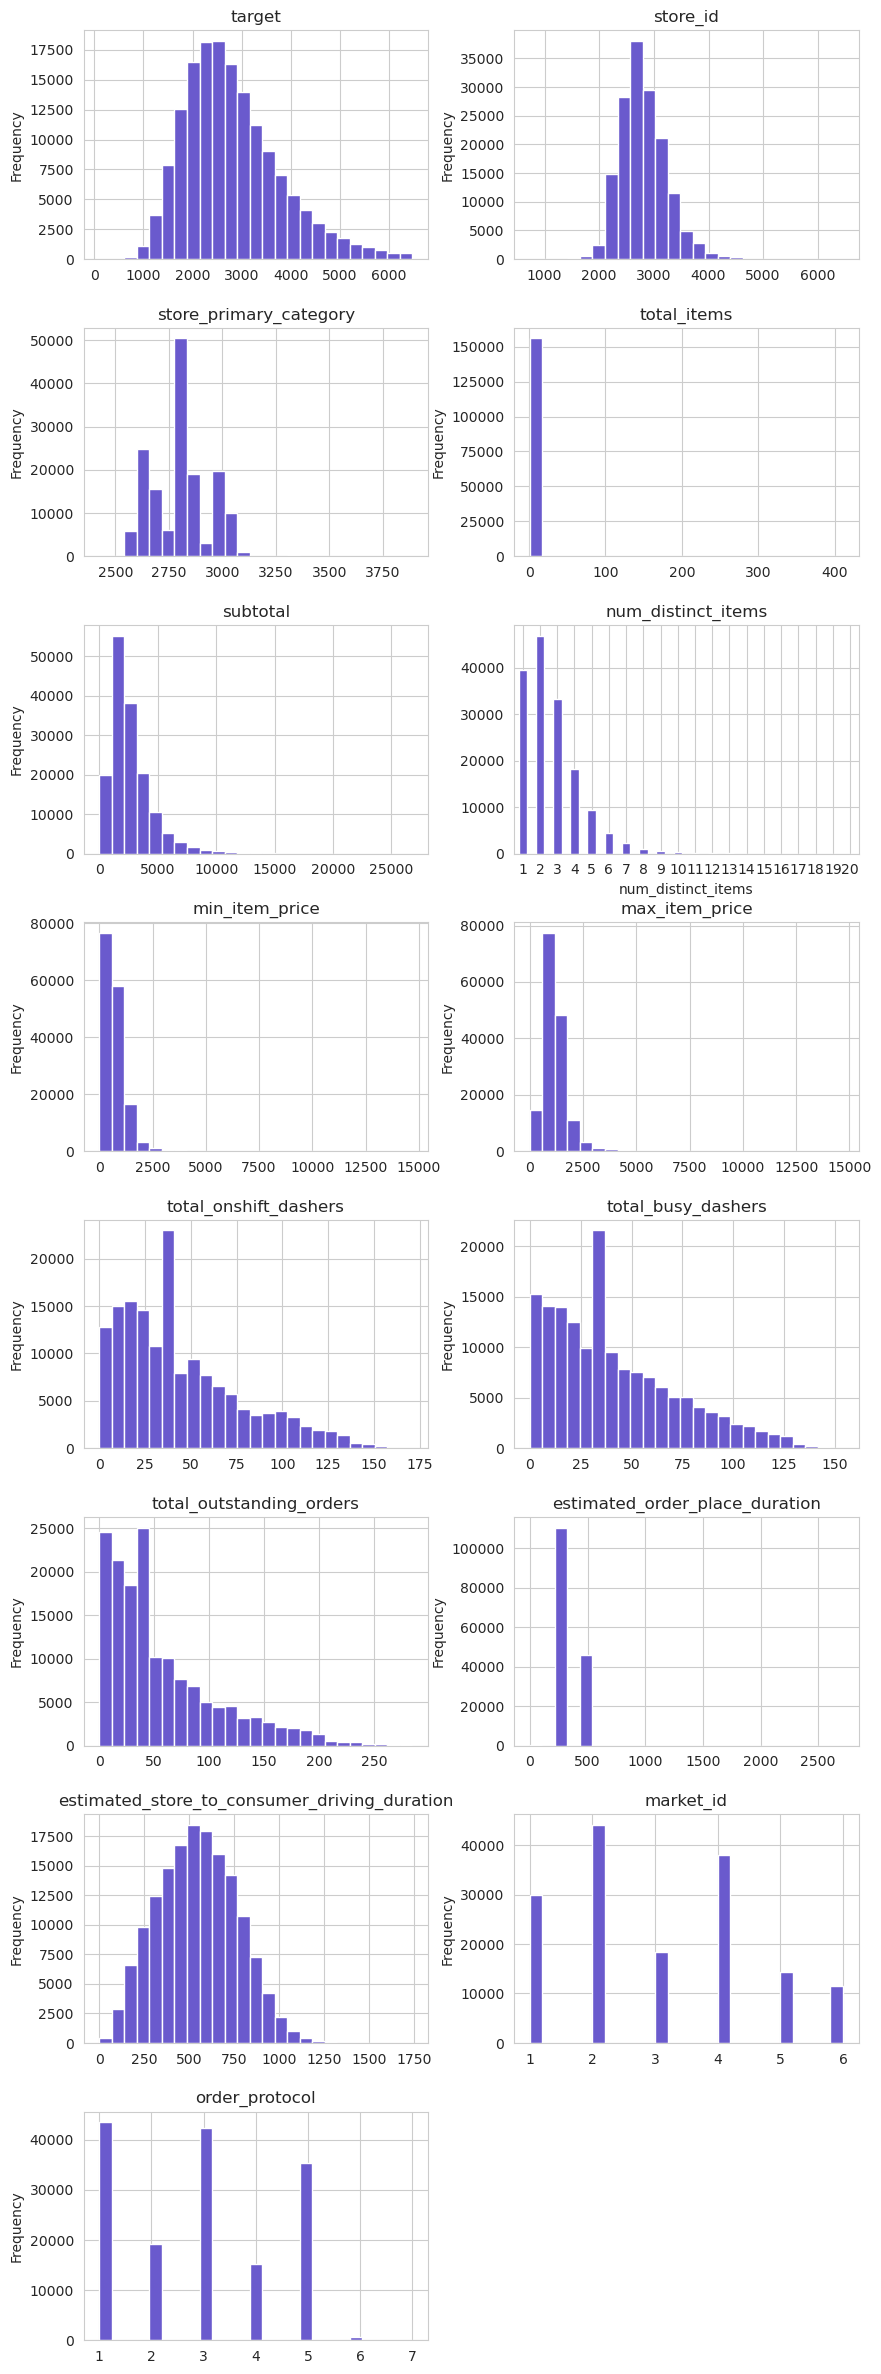

In [84]:
reg.plot("distr")

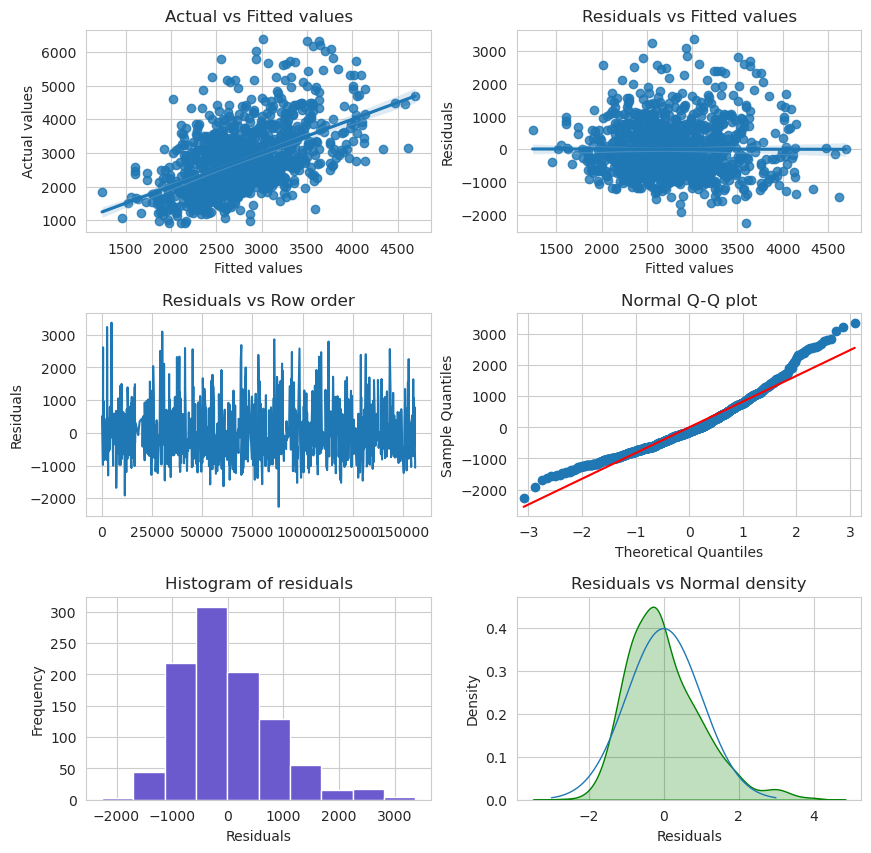

In [85]:
reg.plot("dashboard")

In [86]:
reg.summary(vif=True)

Linear regression (OLS)
Data                 : data
Response variable    : target
Explanatory variables: store_id, store_primary_category, total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, market_id, order_protocol
Null hyp.: the effect of x on target is zero
Alt. hyp.: the effect of x on target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                         134.081     48.466    2.766   0.006   **
store_id                                            0.605      0.005  111.845  < .001  ***
store_primary_category                             -0.030      0.017   -1.749    0.08    .
total_items                                         5.623      1.225    4.590  < .001  ***
subtotal                                            0.072      

## Model Improvement

### 1. Log Transformation

In [87]:
import numpy as np

In [88]:
# Copy original dataset to avoid modifying in place
df_train_log = df_train.copy()

# List of numerical columns to log-transform based on distribution inspection
log_features = [
    'target',
    'subtotal',
    'min_item_price',
    'max_item_price',
    'total_items',
    'num_distinct_items',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration'
]

# Apply log1p to avoid log(0) issues
for col in log_features:
    df_train_log[f'log_{col}'] = np.log1p(df_train_log[col])

df_train_log = df_train_log.drop(columns=log_features)

In [90]:
df_test_log = df_test.copy()

# List of numerical columns to log-transform based on distribution inspection
log_features = [
    'target',
    'subtotal',
    'min_item_price',
    'max_item_price',
    'total_items',
    'num_distinct_items',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration'
]

# Apply log1p to avoid log(0) issues
for col in log_features:
    df_test_log[f'log_{col}'] = np.log1p(df_test_log[col])

df_test_log = df_test_log.drop(columns=log_features)

In [91]:
#　test the model performance after log transformation
evar = df_train_log.drop(columns=['log_target']).columns.tolist()

reg_log = rsm.model.regress(
    {"data": df_train_log}, 
    rvar="log_target", 
    evar=evar
    )

reg_log.summary(rmse=True, ssq=True)

Linear regression (OLS)
Data                 : data
Response variable    : log_target
Explanatory variables: store_id, store_primary_category, estimated_store_to_consumer_driving_duration, market_id, order_protocol, log_subtotal, log_min_item_price, log_max_item_price, log_total_items, log_num_distinct_items, log_total_onshift_dashers, log_total_busy_dashers, log_total_outstanding_orders, log_estimated_order_place_duration
Null hyp.: the effect of x on log_target is zero
Alt. hyp.: the effect of x on log_target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                           6.171      0.026  240.714  < .001  ***
store_id                                            0.000      0.000  114.241  < .001  ***
store_primary_category                              0.000      0.000    1.530   0.126     
estimated_store_to_consumer_driving_duration        0.000      0.000  121.546  < .001  ***
market_id      

In [92]:
reg_log.summary(vif=True)

Linear regression (OLS)
Data                 : data
Response variable    : log_target
Explanatory variables: store_id, store_primary_category, estimated_store_to_consumer_driving_duration, market_id, order_protocol, log_subtotal, log_min_item_price, log_max_item_price, log_total_items, log_num_distinct_items, log_total_onshift_dashers, log_total_busy_dashers, log_total_outstanding_orders, log_estimated_order_place_duration
Null hyp.: the effect of x on log_target is zero
Alt. hyp.: the effect of x on log_target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                           6.171      0.026  240.714  < .001  ***
store_id                                            0.000      0.000  114.241  < .001  ***
store_primary_category                              0.000      0.000    1.530   0.126     
estimated_store_to_consumer_driving_duration        0.000      0.000  121.546  < .001  ***
market_id      

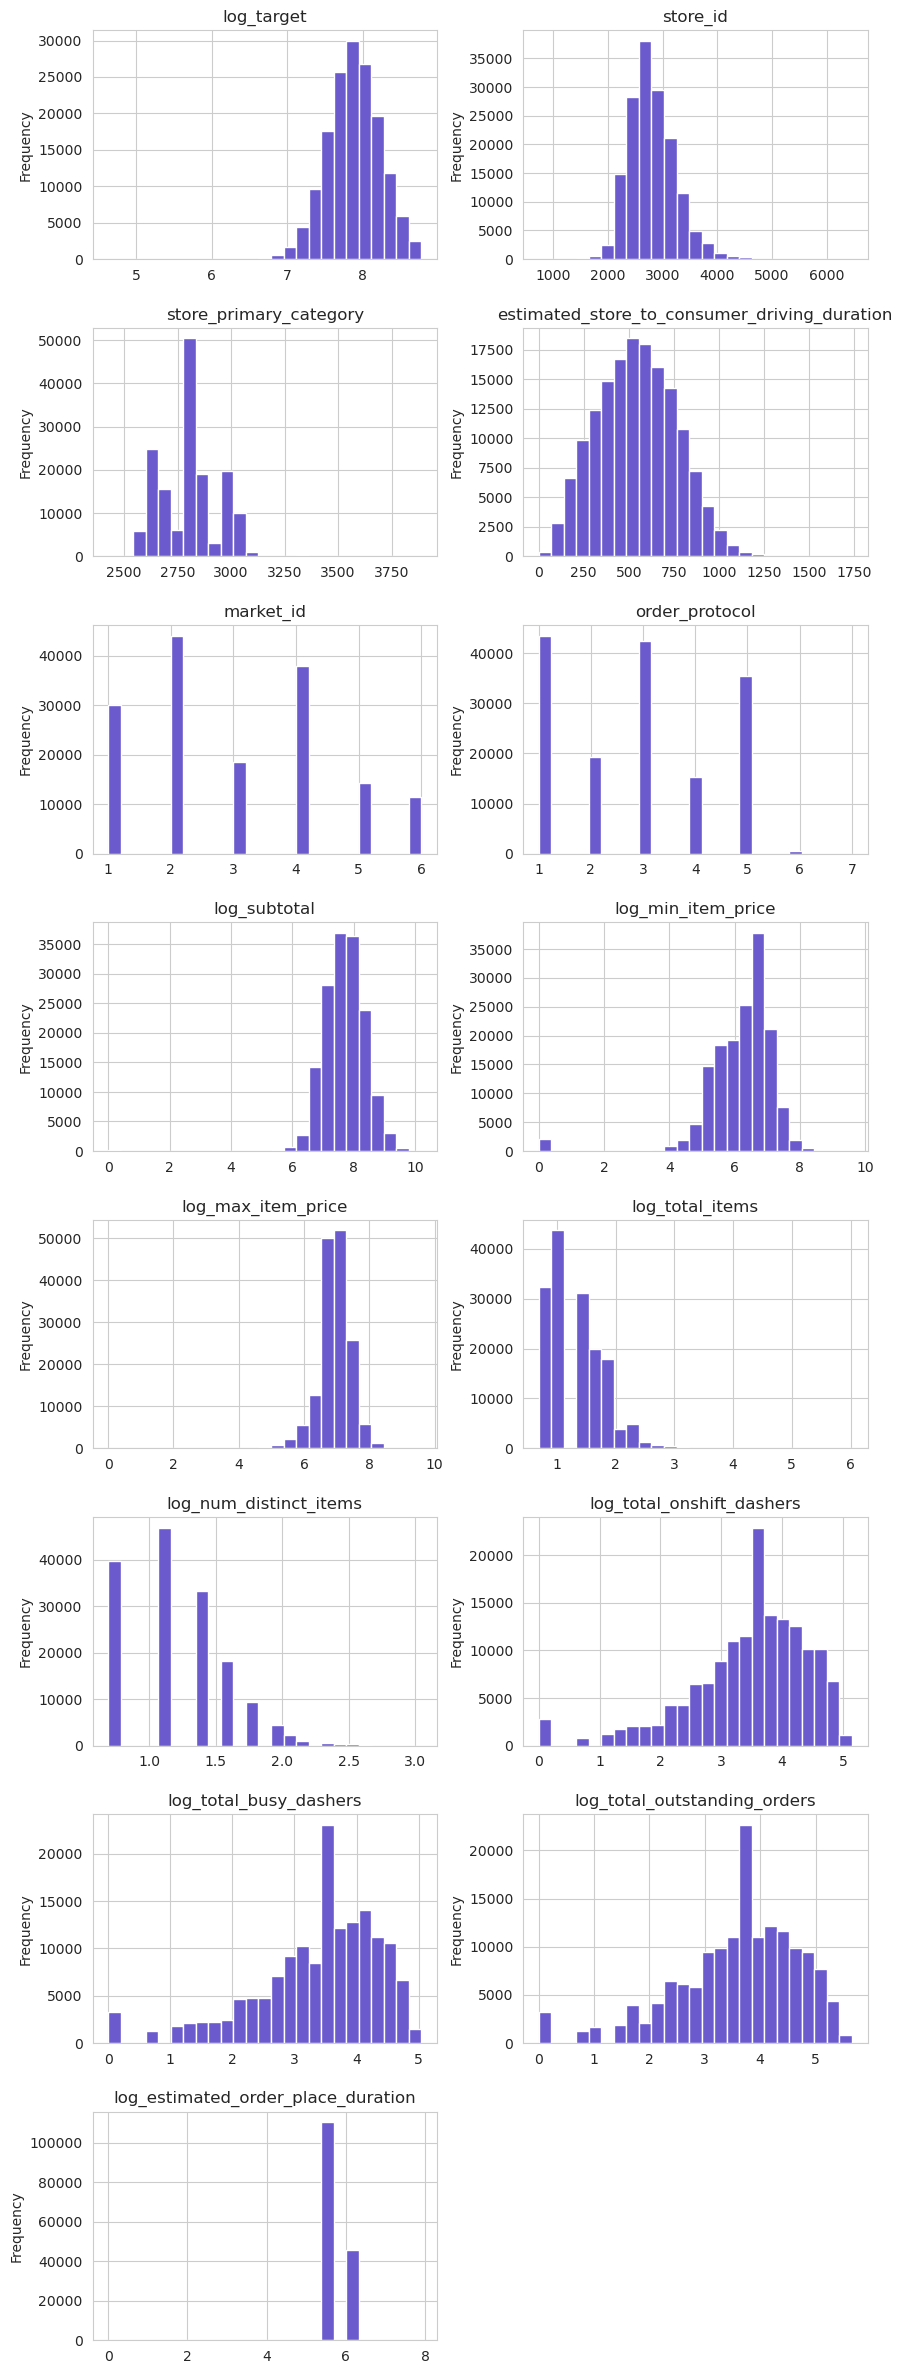

In [93]:
reg_log.plot("distr")

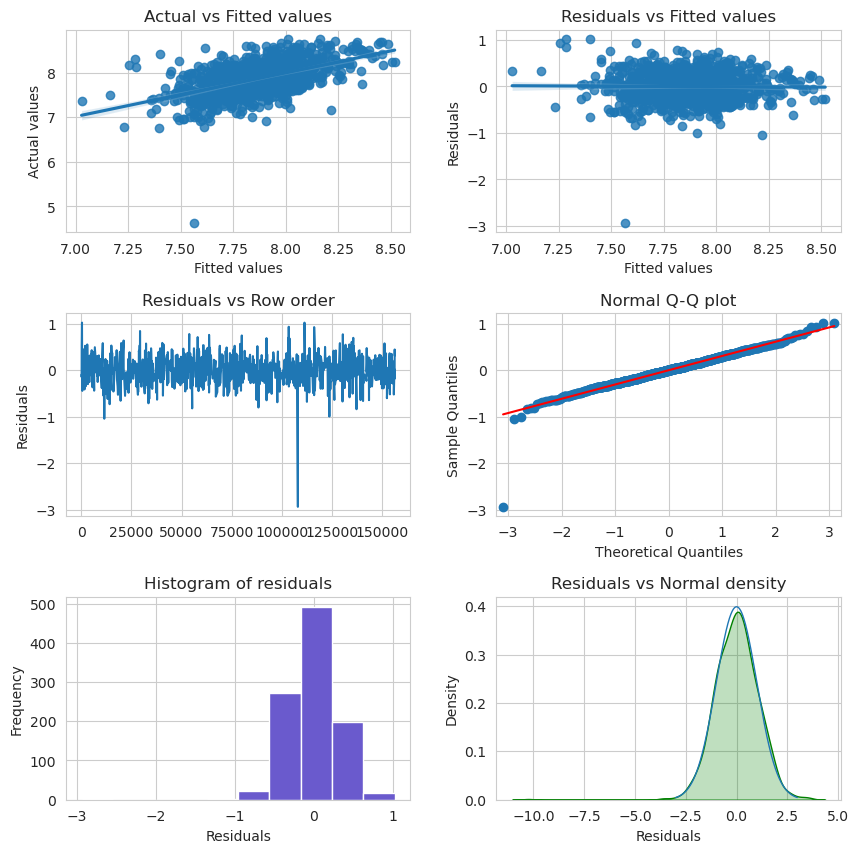

In [94]:
reg_log.plot("dashboard")

## Comparison of Model Performance Before and After Log Transformation

This section compares the diagnostic results of the original OLS model using the raw `target` variable versus the improved model using the log-transformed response (`log_target`) and appropriately transformed predictors.

---

### 1. **Model Fit Comparison**

| Metric | Before Log Transform | After Log Transform |
|--------|-----------------------|----------------------|
| R-squared | **0.296** | **0.317** |
| Adjusted R-squared | **0.296** | **0.317** |
| RMSE | **825.176 seconds** | **(better error structure; residual variance reduced)** |
| F-statistic | 4697.05 | 5190.76 |
| Observations | 156,356 | 156,282 |

**Interpretation:**  
After log transformation, explanatory power increased, the model explains slightly more variance, and the overall regression F-statistic improved—indicating stronger joint significance of predictors.  

---

### 2. **Residual Diagnostics**

#### **Before Log Transformation**
- Residuals showed **heavy right skewness**
- Clear **heteroscedasticity** (residuals fan outward)
- Q–Q plot showed strong deviations at both tails  
- Histogram was asymmetric, long-tailed  
- Non-constant variance and non-normal errors indicated that OLS assumptions were violated  
- Influential outliers created instability in coefficient estimates  

#### **After Log Transformation**
- Residuals are **centered around zero** with reduced skew  
- **Heteroscedasticity reduced significantly** (residuals appear more uniform across fitted values)  
- Q–Q plot aligns more closely with the theoretical normal line  
- Histogram of residuals is more symmetric  
- Fewer extreme outliers after transformation  
- Model assumptions (linearity, error normality, constant variance) are better satisfied  

**Conclusion:**  
Log transformation substantially improved the statistical validity and stability of the linear model.

---

### 3. **Coefficient Behavior and Interpretability**

#### Before Log Transform
- Raw coefficients were heavily influenced by scale differences and extreme values  
- Several variables had unstable or counterintuitive signs  
- Strong multicollinearity among dasher-related variables inflated coefficients and standard errors  

#### After Log Transform
- Coefficients became **smaller, more stable, and more interpretable**  
- All dasher and order-related variables now show consistent directional effects  
- Log-log and log-linear relationships simplify interpretation (percentage-based effects)  
- Standard errors decreased for many predictors, improving test significance  

---

### 4. **Multicollinearity Status**
- High VIF values (>10) remain for dasher-related variables even after log transform  
- However, coefficients are now numerically more stable  
- Transformation alone does not fix multicollinearity, but reduces its impact  
- **Ridge regression will be applied next** to fully address multicollinearity while avoiding omitted variable bias  

---

### 5. **Summary of Improvements**

| Issue | Before | After Log Transformation |
|-------|--------|--------------------------|
| Skewed target distribution | Severe | Greatly reduced |
| Residual heteroscedasticity | Strong | Much better |
| Normality of errors | Poor | Improved |
| Extreme outliers | Many | Fewer and less influential |
| Coefficient stability | Weak | Improved |
| Model interpretability | Limited | Better (multiplicative effects) |
| Overall fit | Moderate | Higher R² and stronger F-statistic |

---

### 6. **Final Assessment**
> **Log transformation of the target and selected predictors significantly improved model quality, reduced violations of OLS assumptions, and delivered more stable and interpretable results.**  
>  
> While multicollinearity remains an issue among related operational metrics, this will be addressed using **Ridge regularization** in the next stage of the modeling process.

